In [1]:
import pandas as pd
import numpy as np
from sklearn.utils._estimator_html_repr import estimator_html_repr

# SQL client

In [2]:
import os

figures = "./figures/"
os.makedirs(figures, exist_ok=True)

In [3]:
def save(fig, filename, path=figures):
    """ Savegarde une figure matplotlib """
    fig.savefig(path + filename, bbox_inches="tight")

def export_diagram(pipeline, filename):
    """ Sauvergarde le diagram d'une pipeline"""
    with open(filename, "w") as f :
        f.write(estimator_html_repr(pipeline))

# Data

Les données extraites de la base de données Azure. `Executer le script extraction.py`. On suppose que les données ont été téléchargée dans le dossier `./data/`.

In [5]:
data_path = './data/data_ext_v4.tsv'

Chargement des données :

In [6]:
df = pd.read_csv(data_path, sep='\t', quoting=3)

In [7]:
df.head()

,tconst,titleType,genre_1,genre_2,genre_3,primaryTitle,isAdult,startYear,runtimeMinutes,actor_1,actor_2,actor_3,director_1,director_2,director_3,averageRating,numVotes
0,tt2291966,movie,Biography,Documentary,Family,Farming 101,False,2012,80.0,nm5174409,NaN,NaN,nm0709664,NaN,NaN,NaN,NaN
1,tt2378115,movie,NaN,NaN,NaN,Cecilia y Juan,False,2012,NaN,nm1570600,nm5021870,NaN,nm3913456,NaN,NaN,NaN,NaN
2,tt2530242,tvMovie,Comedy,NaN,NaN,Das Millionen Rennen,False,2012,89.0,nm0695127,nm0517885,nm0499671,nm1054437,NaN,NaN,6.1,68.0
3,tt27505330,movie,Drama,NaN,NaN,Nevada,False,2023,89.0,nm14752449,nm1235719,nm15159468,nm3807259,nm6281196,NaN,6.2,10.0
4,tt22871554,movie,Drama,Mystery,Thriller,A Haunting Winter's Tale,False,2022,65.0,nm13391370,nm13392830,nm13392832,nm13390267,NaN,NaN,7.7,6.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669273 entries, 0 to 669272
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          669273 non-null  object 
 1   titleType       669273 non-null  object 
 2   genre_1         633878 non-null  object 
 3   genre_2         197851 non-null  object 
 4   genre_3         90136 non-null   object 
 5   primaryTitle    669271 non-null  object 
 6   isAdult         669273 non-null  bool   
 7   startYear       669273 non-null  int64  
 8   runtimeMinutes  407667 non-null  float64
 9   actor_1         444242 non-null  object 
 10  actor_2         394240 non-null  object 
 11  actor_3         366097 non-null  object 
 12  director_1      392268 non-null  object 
 13  director_2      36476 non-null   object 
 14  director_3      5918 non-null    object 
 15  averageRating   320451 non-null  float64
 16  numVotes        320451 non-null  float64
dtypes: bool(1)

In [9]:
df['isAdult'] = df['isAdult'].astype(int)

# Système de Recommandation

Utilization d'un countvectorizer au lieu d'un MultiLabelBinarizer car Multilabel Binarizer n'est pas fait pour fonctionner dans une pipeline (*cf. [sckit-learn github issues 11309](https://github.com/scikit-learn/scikit-learn/issues/11309)*).

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer

In [479]:
numeric_features = ["isAdult", "startYear", "runtimeMinutes", "averageRating", "numVotes"]
categorical_features = ['titleType', 'genre_1', 'genre_2', 'genre_3']
text_features = ["tconst", "actor_1", "actor_2", "actor_3", "director_1", "director_2", "director_3"]

In [480]:
numeric_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scl', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=set))])
textual_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='')), ('vec', CountVectorizer(analyzer=list))])

In [481]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", textual_transformer, categorical_features)
    ]
)

In [482]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scl', StandardScaler())]),
                                 ['isAdult', 'startYear', 'runtimeMinutes',
                                  'averageRating', 'numVotes']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('vec',
                                                  CountVectorizer(analyzer=<class 'set'>))]),
                                 ['titleType', 'genre_1', 'genre_2',
                                  'genre_3']),
                                ('txt',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('vec',
                                                  CountVectorizer(analyzer=<class 'list'>))]),
                                 ['titleType', 'genre_1', 'genre_2',
                                  'genre_3'])])

In [483]:
preproc_output = preprocessor.fit_transform(df)

In [484]:
filename = './data/vectorized_db2.npy'

np.save(filename, preproc_output.todense())

In [485]:
class RecommanderSystem :

    def __init__(self, n=5, data_path='./data/vectorized_db2.npy'):
        self._n = n
        self.load_data(data_path)
    
    def load_data(self, data_path):
        self._X = np.load(data_path, allow_pickle=True)
        print(self._X.shape)
    
    def recommand(self, idx):
        Y = self._X[idx,:].reshape(1,-1)

        result = cosine_similarity(np.delete(self._X, idx, axis=0), Y).reshape(-1)
        
        idxs = np.argpartition(result, -self._n)[-self._n:]
        idxs = idxs[np.argsort(result[idxs])]
        return idxs

In [486]:
rec = RecommanderSystem(10, filename)

(669273, 69)


In [487]:
idx = 191479
df.loc[idx, 'primaryTitle']

'Harry Potter and the Prisoner of Azkaban'

In [488]:
df.loc[rec.recommand(idx), 'primaryTitle']

453388                                      Professor White
403320                                         The Tuomolat
495105                                          Odd Man Out
371299                                         Go Go Squid!
282542    Los sueños de Elma - Historia de una madre de ...
178527         Harry Potter and the Deathly Hallows: Part 2
66027          Harry Potter and the Deathly Hallows: Part 1
501919                                My 10 Minutes Stories
45495               Harry Potter and the Chamber of Secrets
369196                                               Exodus
Name: primaryTitle, dtype: object

# Prédiction de Popularité

## utils


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def regression_report(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred)
    mse_train = mean_squared_error(y_train,y_pred)
    rmse_train = np.sqrt(mse_train)

    y_pred = model.predict(X_test)
    
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test,y_pred)
    rmse_test = np.sqrt(mse_test)

    return pd.DataFrame({
        'r2' : [r2_train, r2_test],
        'MAE' : [mae_train, mae_test],
        'MSE' : [mse_train, mae_test],
        'RMSE' : [rmse_train, rmse_test],
        'index' : ['train', 'test'] 
    }, columns=['index', 'r2', 'MAE', 'MSE', 'RMSE']).set_index('index')

def plot_pred_actual(y, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_pred, y, c='b', alpha=0.1)
    plt.xlabel("Prediction")
    plt.ylabel("Valeur Réelle")
    plt.title("Comparaison Réalité-Prédiction")

    return fig

class GridSearchOptimizer:
    def __init__(self, pipeline, param_grid):
        self.pipeline = pipeline
        self.param_grid = param_grid
        
        self.grid_search = None
        self.best_model = None
        self.results = None
    
    def fit(self, X_train, y_train, n_splits = 5):
        # Scoring metrics
        scoring = {
            'r2':   'r2',
            'mae':  'neg_mean_absolute_error',
            'mse':  'neg_mean_squared_error',
            'rmse': 'neg_root_mean_squared_error',
        }
        
        # Grid search
        self.grid_search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            scoring=scoring,
            refit='mse',
            cv=5,
            verbose=4,
        )
        
        self.grid_search.fit(X_train, y_train)
        self.results = pd.DataFrame(self.grid_search.cv_results_)
        self.best_model = self.grid_search.best_estimator_

def display_metrics(results, params):
    return results[['param_'+ p for p in params]+['mean_fit_time', 'mean_score_time',
       'mean_test_r2','mean_test_mae',
       'mean_test_mse','mean_test_rmse']].sort_values(by=['mean_test_rmse', 'mean_test_mae'], ascending=False)


## Data prepation

In [12]:
df_ratings = df[df['averageRating'].notna()]
df_ratings.info()


<class 'pandas.core.frame.DataFrame'>
Index: 320451 entries, 2 to 669271
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          320451 non-null  object 
 1   titleType       320451 non-null  object 
 2   genre_1         314103 non-null  object 
 3   genre_2         141994 non-null  object 
 4   genre_3         69120 non-null   object 
 5   primaryTitle    320450 non-null  object 
 6   isAdult         320451 non-null  int64  
 7   startYear       320451 non-null  int64  
 8   runtimeMinutes  246872 non-null  float64
 9   actor_1         253580 non-null  object 
 10  actor_2         237432 non-null  object 
 11  actor_3         228699 non-null  object 
 12  director_1      218053 non-null  object 
 13  director_2      20668 non-null   object 
 14  director_3      3536 non-null    object 
 15  averageRating   320451 non-null  float64
 16  numVotes        320451 non-null  float64
dtypes: float64(3), 

In [13]:
df_y = df_ratings['averageRating']
df_X = df_ratings.drop(columns=['averageRating', 'numVotes'])

In [14]:
df_X.head()

,tconst,titleType,genre_1,genre_2,genre_3,primaryTitle,isAdult,startYear,runtimeMinutes,actor_1,actor_2,actor_3,director_1,director_2,director_3
2,tt2530242,tvMovie,Comedy,NaN,NaN,Das Millionen Rennen,0,2012,89.0,nm0695127,nm0517885,nm0499671,nm1054437,NaN,NaN
3,tt27505330,movie,Drama,NaN,NaN,Nevada,0,2023,89.0,nm14752449,nm1235719,nm15159468,nm3807259,nm6281196,NaN
4,tt22871554,movie,Drama,Mystery,Thriller,A Haunting Winter's Tale,0,2022,65.0,nm13391370,nm13392830,nm13392832,nm13390267,NaN,NaN
5,tt6854792,movie,Drama,Romance,NaN,Sriramudinta Srikrishnudanta,0,2017,129.0,nm8970446,nm8970447,nm10962932,nm8970443,NaN,NaN
6,tt10429264,movie,Documentary,NaN,NaN,Fabulous,0,2019,52.0,nm8838626,NaN,NaN,nm5091578,NaN,NaN


In [15]:
from sklearn.preprocessing import RobustScaler
# Center ratings
rscl = RobustScaler()
df_y = rscl.fit_transform(df_y.to_frame()).ravel()
df_y

array([-0.26315789, -0.21052632,  0.57894737, ..., -1.42105263,
        0.05263158,  0.63157895], shape=(320451,))

# Test Train Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

# Pipeline

In [17]:
numeric_features = ["isAdult", "startYear", "runtimeMinutes"]
categorical_features = ['genre_1', 'genre_2', 'genre_3']
text_features = ["actor_1", "actor_2", "actor_3", "director_1", "director_2", "director_3"]

In [20]:
numeric_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)), ('std', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='None')), ('vec', CountVectorizer(analyzer=list))])
textual_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='None')), ('vec', TfidfVectorizer(analyzer=list, min_df=2, max_features=10000)), ('svd', TruncatedSVD(n_components=200)), ('std', MinMaxScaler())])

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", textual_transformer, text_features)
    ]
)

## Régression Linéaire

In [23]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(steps=[('preproc', preprocessor), ('linreg', LinearRegression())])

params = {
    'linreg__fit_intercept' : [True, False],
}
optim = GridSearchOptimizer(pipeline, params)


In [24]:
pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['isAdult', 'startYear',
                                                   'runtimeMinutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   CountVectorizer(analyzer=<class 'list'>))]),
                                                  ['g..._2',
                                                   'genre_3']),
                                                 ('txt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200)),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['actor_1', 'actor_2',
                                                   'actor_3', 'director_1',
                                                   'director_2',
                                                   'director_3'])])),
                ('linreg', LinearRegression())])

In [25]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END linreg__fit_intercept=True; mae: (test=-0.565) mse: (test=-6.481) r2: (test=-9.485) rmse: (test=-2.546) total time=  16.8s
[CV 2/5] END linreg__fit_intercept=True; mae: (test=-0.551) mse: (test=-0.506) r2: (test=0.172) rmse: (test=-0.711) total time=  16.6s
[CV 3/5] END linreg__fit_intercept=True; mae: (test=-0.549) mse: (test=-0.507) r2: (test=0.176) rmse: (test=-0.712) total time=  17.3s
[CV 4/5] END linreg__fit_intercept=True; mae: (test=-0.550) mse: (test=-0.506) r2: (test=0.171) rmse: (test=-0.711) total time=  17.0s
[CV 5/5] END linreg__fit_intercept=True; mae: (test=-0.554) mse: (test=-0.511) r2: (test=0.171) rmse: (test=-0.715) total time=  17.3s
[CV 1/5] END linreg__fit_intercept=False; mae: (test=-0.564) mse: (test=-6.532) r2: (test=-9.568) rmse: (test=-2.556) total time=  17.1s
[CV 2/5] END linreg__fit_intercept=False; mae: (test=-0.551) mse: (test=-0.506) r2: (test=0.172) rmse: (test=-0.711) total time

In [26]:
optim.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linreg__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,16.465294,0.225930,0.630560,0.057654,True,{'linreg__fit_intercept': True},-9.485147,0.171701,0.176151,0.171328,...,2.389558,1,-2.545868,-0.711166,-0.712260,-0.711238,-0.715025,-1.079111,0.733379,1
1,16.446851,0.251684,0.598911,0.020957,False,{'linreg__fit_intercept': False},-9.567513,0.171704,0.175232,0.171165,...,2.409844,2,-2.555848,-0.711165,-0.712657,-0.711308,-0.715125,-1.081221,0.737315,2


In [27]:
regression_report(optim.best_model, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE
index,,,,
train,0.176312,0.550718,0.506090,0.711400
test,0.173425,0.552901,0.552901,0.713376


## Regression Ridge

In [38]:
from sklearn.linear_model import Ridge

pipeline = Pipeline(steps=[('preproc', preprocessor), ('ridge', Ridge())])

params = {
    'ridge__fit_intercept' : [True, False],
    'ridge__alpha' : [1e-3, 1e-2, 1e-1, 1, 10, 100]
}
optim = GridSearchOptimizer(pipeline, params)

In [39]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.565) mse: (test=-6.522) r2: (test=-9.550) rmse: (test=-2.554) total time=   9.8s
[CV 2/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.551) mse: (test=-0.507) r2: (test=0.170) rmse: (test=-0.712) total time=   9.6s
[CV 3/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.550) mse: (test=-0.508) r2: (test=0.175) rmse: (test=-0.713) total time=   9.5s
[CV 4/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.550) mse: (test=-0.506) r2: (test=0.171) rmse: (test=-0.711) total time=   9.5s
[CV 5/5] END ridge__alpha=0.001, ridge__fit_intercept=True; mae: (test=-0.554) mse: (test=-0.511) r2: (test=0.172) rmse: (test=-0.715) total time=   9.9s
[CV 1/5] END ridge__alpha=0.001, ridge__fit_intercept=False; mae: (test=-0.565) mse: (test=-6.434) r2: (test=-9.409) rmse: (test=-2.537) total time=  10.1s
[CV 2/5] END

In [40]:
optim.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_ridge__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,9.395347,0.131262,0.376204,0.021499,0.001,True,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",-9.550258,0.170432,0.175071,...,2.405537,12,-2.553760,-0.711711,-0.712727,-0.711432,-0.714667,-1.080859,0.736451,12
1,11.135501,1.141942,0.465658,0.059072,0.001,False,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",-9.408819,0.170311,0.175440,...,2.370564,11,-2.536584,-0.711763,-0.712568,-0.711285,-0.714927,-1.077425,0.729581,11
2,10.403069,0.380314,0.418666,0.020254,0.010,True,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",-9.321631,0.170583,0.175177,...,2.348992,10,-2.525938,-0.711646,-0.712681,-0.711019,-0.715287,-1.075314,0.725313,10
3,10.135212,0.405248,0.405341,0.003475,0.010,False,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",-9.310396,0.170607,0.175579,...,2.346280,9,-2.524563,-0.711636,-0.712508,-0.710852,-0.715179,-1.074948,0.724809,9
4,9.672339,0.114754,0.416656,0.015181,0.100,True,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",-8.505470,0.170480,0.175735,...,2.147157,7,-2.424015,-0.711691,-0.712440,-0.711648,-0.715067,-1.054972,0.684523,7
5,9.710343,0.202559,0.398991,0.004746,0.100,False,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",-8.662193,0.169530,0.175260,...,2.185800,8,-2.443917,-0.712098,-0.712645,-0.711196,-0.715664,-1.059104,0.692408,8
6,9.834876,0.227292,0.407824,0.006346,1.000,True,"{'ridge__alpha': 1, 'ridge__fit_intercept': True}",-4.140896,0.172220,0.175247,...,1.068007,5,-1.782658,-0.710944,-0.712651,-0.711586,-0.715373,-0.926642,0.428010,5
7,9.515415,0.153595,0.398653,0.009945,1.000,False,"{'ridge__alpha': 1, 'ridge__fit_intercept': Fa...",-4.167028,0.170903,0.176262,...,1.074570,6,-1.787183,-0.711509,-0.712212,-0.711159,-0.714963,-0.927405,0.429891,6
8,10.525599,1.566435,0.422723,0.026637,10.000,True,"{'ridge__alpha': 10, 'ridge__fit_intercept': T...",-0.107753,0.171367,0.175372,...,0.070741,4,-0.827504,-0.711310,-0.712597,-0.711468,-0.715562,-0.735688,0.045933,4
9,10.771618,0.557574,0.452308,0.071780,10.000,False,"{'ridge__alpha': 10, 'ridge__fit_intercept': F...",-0.105447,0.171711,0.174173,...,0.070074,3,-0.826642,-0.711162,-0.713115,-0.711936,-0.715374,-0.735646,0.045520,3


In [41]:
regression_report(optim.best_model, X_train, X_test, y_train,  y_test)


,r2,MAE,MSE,RMSE
index,,,,
train,0.166881,0.553885,0.511884,0.715461
test,0.165620,0.555526,0.555526,0.716736


## Random Forest

In [349]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[('preproc', preprocessor), ('rff', RandomForestRegressor())])

params = {
    'rff__' : l
}

optim = GridSearchOptimizer(pipeline, params)

In [350]:
optim.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scl',
                                                                   StandardScaler())]),
                                                  ['isAdult', 'startYear',
                                                   'runtimeMinutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   CountVectorizer(analyzer=<class 'set'>))]),
                                                  ['genre_1', 'genre_2',
                                                   'genre_3']),
                                                 ('txt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   CountVectorizer(analyzer=<class 'list'>))]),
                                                  ['genre_1', 'genre_2',
                                                   'genre_3'])])),
                ('rff', RandomForestRegressor())])

In [ ]:
optim.results

In [360]:
regression_report(pipeline, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE,exp_std
index,,,,,
train,0.488385,0.769875,1.137227,1.066409,0.488387
test,0.120718,1.068134,1.068134,1.394456,0.120724


## Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline(steps=[('preproc', preprocessor), ('gbr', GradientBoostingRegressor())])

#params = {
    #"gbr__n_estimators": [50, 100, 200, 500],
 #   "gbr__max_depth": [2, 4],
  #  "gbr__min_samples_split": [3,5],
    #"gbr__learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
   # "gbr__loss": ["squared_error"],
#}

optim = GridSearchOptimizer(pipeline, params)

In [32]:
optim.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END gbr__loss=squared_error, gbr__max_depth=2, gbr__min_samples_split=3; mae: (test=-0.535) mse: (test=-0.488) r2: (test=0.210) rmse: (test=-0.699) total time=12.3min


KeyboardInterrupt: 

In [ ]:
optim.results

In [ ]:
optim.results.loc[7, 'params']

In [33]:
params = {
    "gbr__n_estimators": [300],
    "gbr__max_depth": [8],
    "gbr__min_samples_split": [6],
    "gbr__learning_rate": [1e-1],
    "gbr__loss": ["squared_error"],
}

optim = GridSearchOptimizer(pipeline, params)

In [35]:
optim.fit(X_train[:10000], y_train[:10000])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END gbr__learning_rate=0.1, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=300; mae: (test=-0.553) mse: (test=-0.534) r2: (test=0.138) rmse: (test=-0.731) total time= 2.0min
[CV 2/5] END gbr__learning_rate=0.1, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=300; mae: (test=-0.548) mse: (test=-0.518) r2: (test=0.165) rmse: (test=-0.720) total time= 2.1min
[CV 3/5] END gbr__learning_rate=0.1, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=300; mae: (test=-0.548) mse: (test=-0.512) r2: (test=0.174) rmse: (test=-0.716) total time= 2.1min
[CV 4/5] END gbr__learning_rate=0.1, gbr__loss=squared_error, gbr__max_depth=8, gbr__min_samples_split=6, gbr__n_estimators=300; mae: (test=-0.552) mse: (test=-0.516) r2: (test=0.157) rmse: (test=-0.718) total time= 3.2min
[CV 5/5] END gbr__learning_rate=0.1, gbr__loss=sq

In [36]:
regression_report(optim.best_model, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE
index,,,,
train,0.166382,0.541522,0.512191,0.715675
test,0.141089,0.554719,0.554719,0.727196


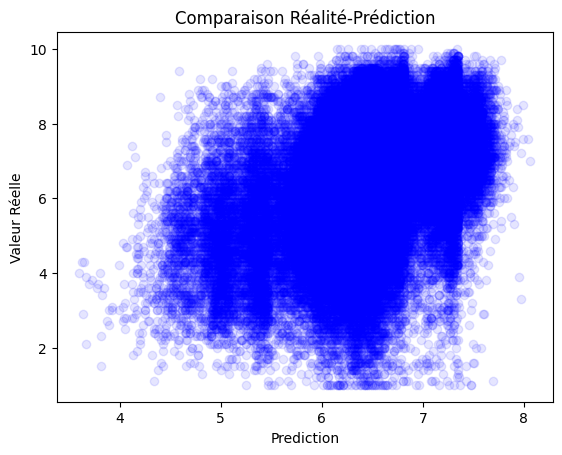

In [42]:
y_pred = rscl.inverse_transform(optim.best_model.predict(X_test).reshape(-1,1))
fig = plot_pred_actual(rscl.inverse_transform(y_test.reshape(-1,1)), y_pred)
plt.show()